## 운영 위험

운영 위험은 부적절하거나 실패한 내부 프로세스 , 인력 , 시스템 또는 외부 이벤트로 인한 직간접적인 손실의 위험을 뜻한다. (Operational risk is defined as the risk of loss resulting from inadequate or failed internal processes, people and systems or from external events) 손실은 직접적일수도 있고 간접적일 수도 있다. 직접적 손실의 예시로는

- 법 절차로 인한 법적 책임
- 절도 또는 자산 감소로 인한 상각
- 세금, 라이선스, 벌금 등으로 인한 규정 준수 문제
- 업무 중단 

간접 비용은 기관의 결정이 미래 불확실한 시기에 손실을 초래하는 일련의 사건을 유발할 수 있다는 점에서 기회비용과 관련을 갖는다.

일반적으로 금융기관은 운용 위험에 따른 손실을 충당하기 위해 일정 금액의 자금을 할당한다. 이를 미예상 손실(unexpected loss)이라고 부른다. 하지만 예상치 못한 손실을 충당하기 위해 적절한 금액을 할당하는 것은 매우 어렵다. 너무 많이 할당하면 해당 금액을 묶어두는데서 생기는 기회비용 문제가 발생하며, 너무 적게 할당한다면 문제가 발생했을 때 자금을 충당하기 위한 유동성 문제가 발생한다.

이 챕터에서는 가장 만연하고 파괴적인 운영 위험으로 간주되는 사기 위험에 초점을 맞추고자 한다.

사기는 일반적으로 다른 사람을 속이기 위해 고안된 의도적 행위, 허위 진술 또는 누락으로 특징지을 수 있다. 사기의 결과로 피해자는 손실을 입거나 가해자는 이익을 얻게 된다. 

이 장에서는 사기 또는 사기 가능성이 있는 작업을 감지하기 위한 ML 모델을 구현하는 방법론을 소개한다.

# Fraud Detection

가장 먼저 다뤄볼 사기 데이터는 신용카드 거래 사기 탐지 데이터이다. 해당 데이터는 브랜든 해리스가 만든 신용카드 거래 사기 탐지 데이터셋이다. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 150   
plt.rcParams['savefig.dpi'] = 150

In [2]:
fraud_data = pd.read_csv('./datasets/fraudTrain.csv')
del fraud_data['Unnamed: 0']

In [3]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

클래스 불균형(Class Imbalance)문제는 모델의 성능에 영향을 미치는 매우 중요한 문제이다. 예를 들어 0.1% 확률로 감염되는 질병이 있다고 가정해보자. 이 경우 어떤 input data에 대해 걸리지 않는다고 예측하는 모델은 99.9%의 정확도를 보인다. 하지만 이 모델은 전혀 쓸모가 없는 모델이다. 즉, 클래스 불균형 문제는 모델의 성능에 중대한 영향을 줄 수 있는 문제이다.

다음은 해당 데이터의 클래스 불균형 여부를 확인하는 과정이다.

is_fraud
0    1289169
1       7506
Name: count, dtype: int64


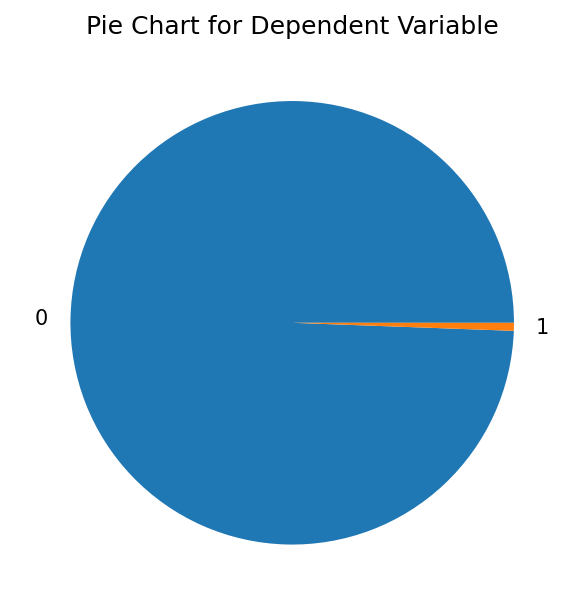

In [4]:
plt.pie(fraud_data['is_fraud'].value_counts(), labels=[0, 1])
plt.title('Pie Chart for Dependent Variable');
print(fraud_data['is_fraud'].value_counts())
plt.show()

이 데이터는 예상대로 클래스 불균형 문제가 매우 심각한 데이터임을 확인할 수 있다. 결측치 확인을 위해서는 missingno 패키지를 이용할 수도 있고, isna().sum()을 이용해서도 확인할 수 있다.

<Axes: >

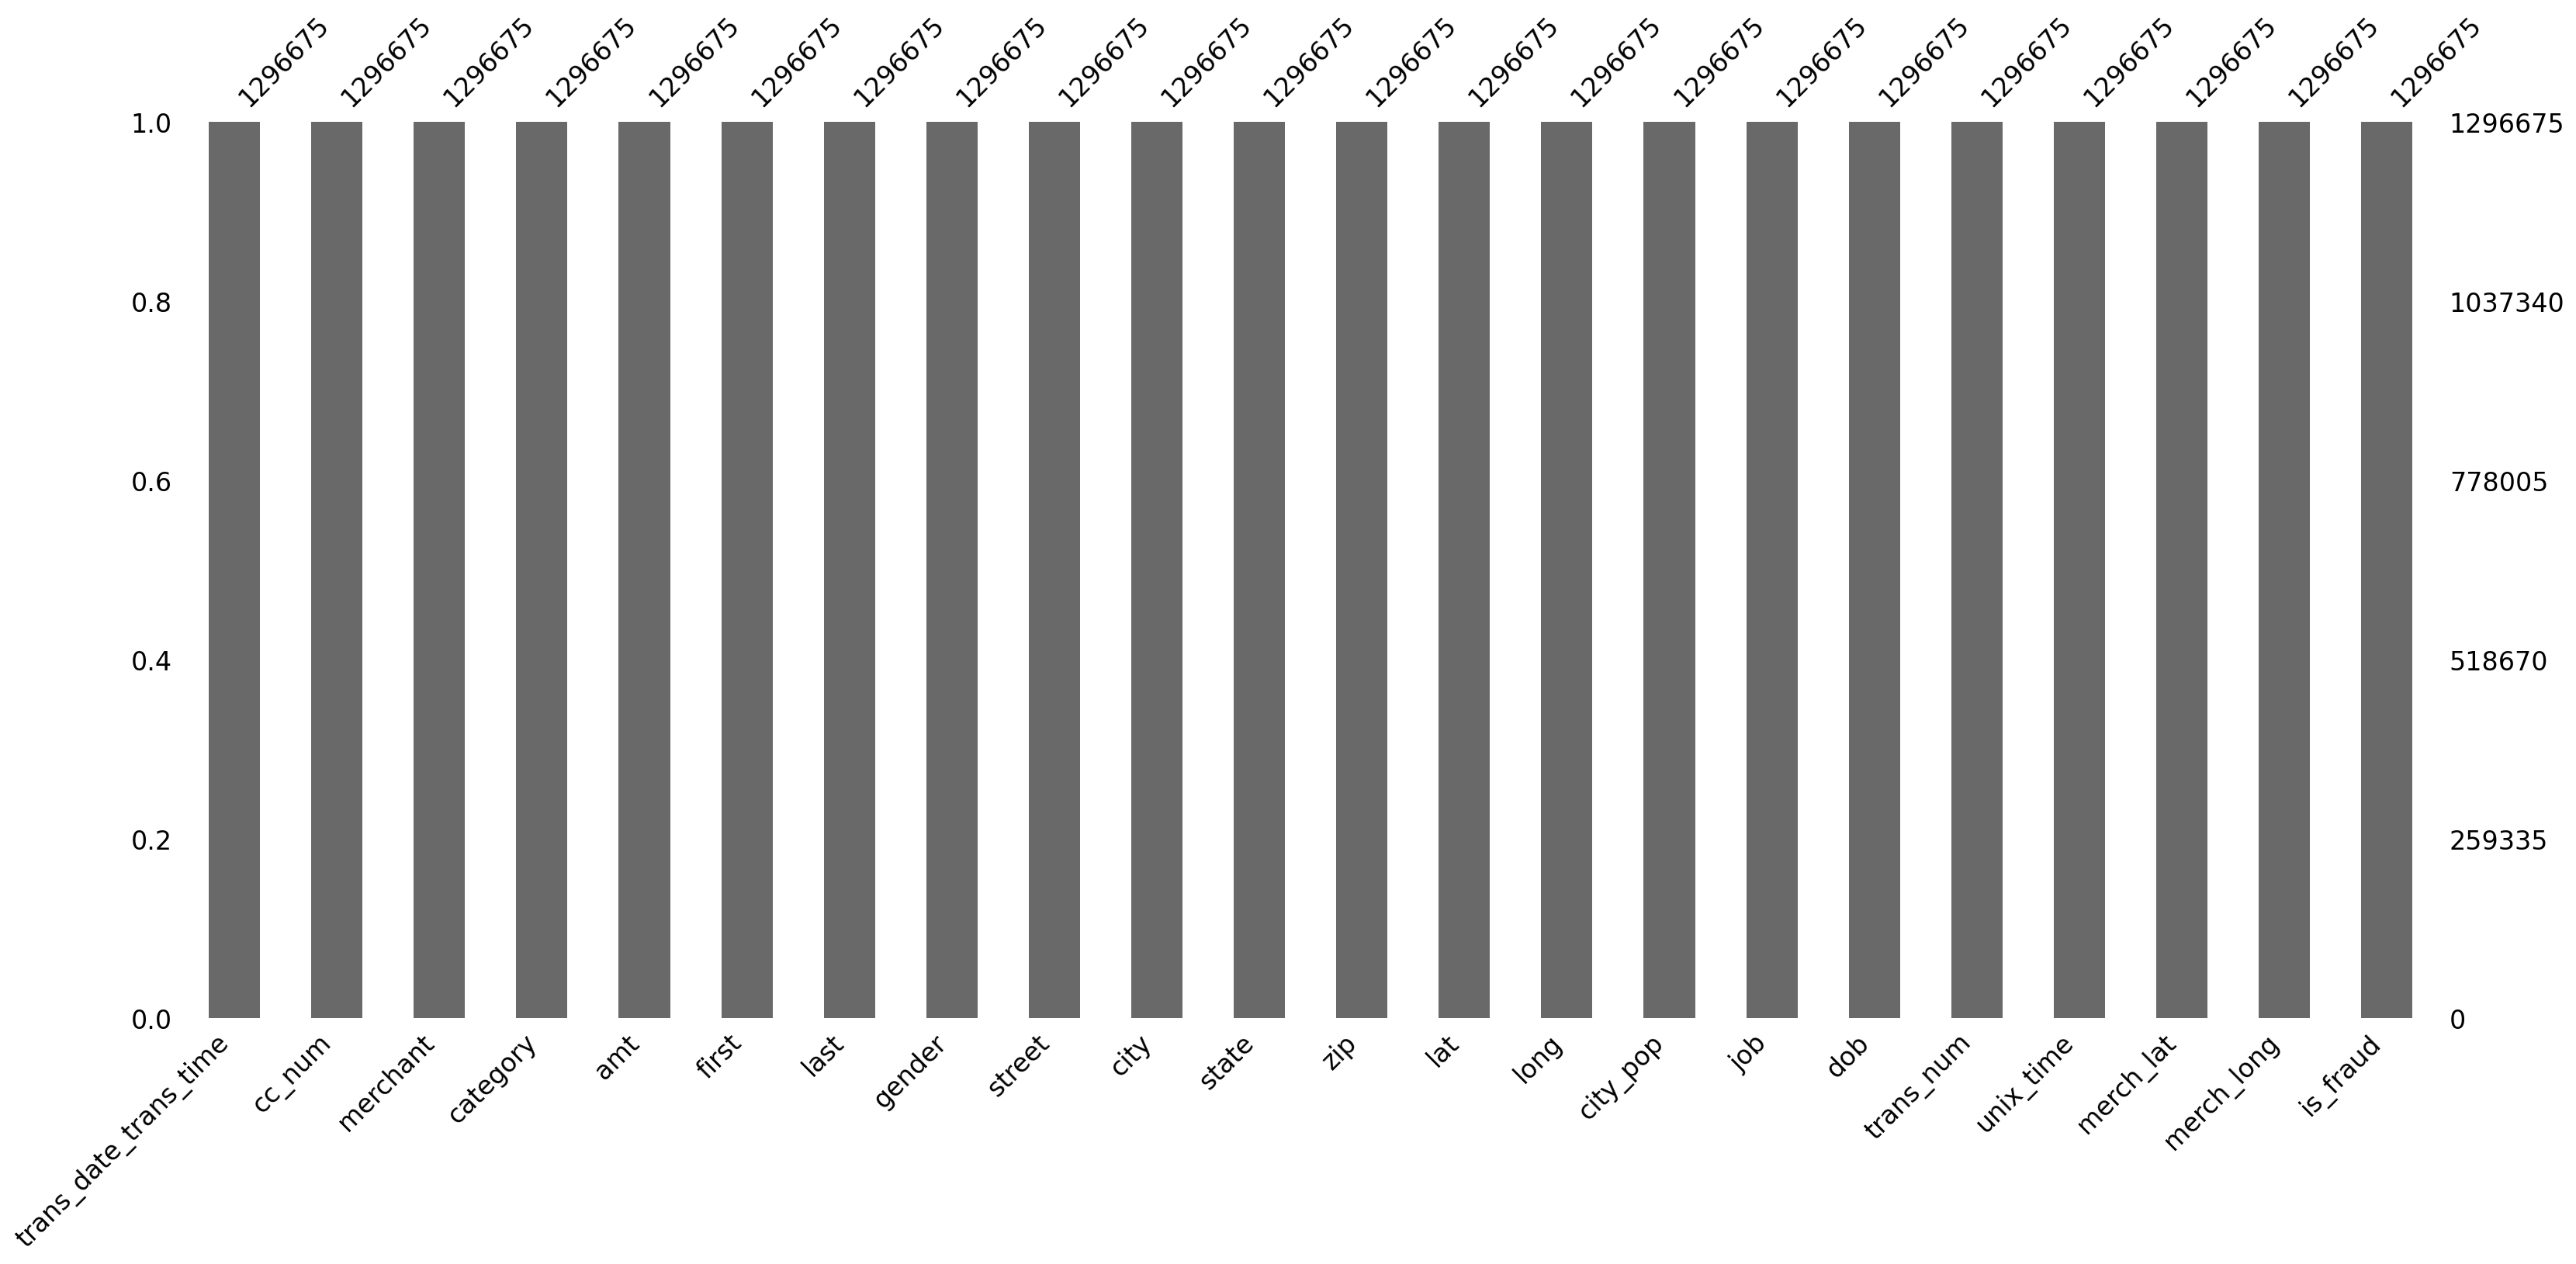

In [5]:
import missingno as msno

msno.bar(fraud_data)


In [6]:
fraud_data.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

위의 방법을 통해 결측치가 존재하지 않음을 확인할 수 있다.

다음은 데이터 전처리 과정이다. info()를 확인해 보면 object 데이터형이 많이 보인다. 해당 데이터를 모두 적절하게 처리해 줘야 한다. 가장 먼저 날짜 데이터인 trans_date_trans_time을 시간 데이터형으로 변환하는 과정이다. 

In [7]:
fraud_data['trans_date_trans_time']

0          2019-01-01 00:00:18
1          2019-01-01 00:00:44
2          2019-01-01 00:00:51
3          2019-01-01 00:01:16
4          2019-01-01 00:03:06
                  ...         
1296670    2020-06-21 12:12:08
1296671    2020-06-21 12:12:19
1296672    2020-06-21 12:12:32
1296673    2020-06-21 12:13:36
1296674    2020-06-21 12:13:37
Name: trans_date_trans_time, Length: 1296675, dtype: object

In [8]:
fraud_data['time'] = pd.to_datetime(fraud_data['trans_date_trans_time'])
del fraud_data['trans_date_trans_time']
fraud_data['time']

0         2019-01-01 00:00:18
1         2019-01-01 00:00:44
2         2019-01-01 00:00:51
3         2019-01-01 00:01:16
4         2019-01-01 00:03:06
                  ...        
1296670   2020-06-21 12:12:08
1296671   2020-06-21 12:12:19
1296672   2020-06-21 12:12:32
1296673   2020-06-21 12:13:36
1296674   2020-06-21 12:13:37
Name: time, Length: 1296675, dtype: datetime64[ns]

In [9]:
fraud_data['days'] = fraud_data['time'].dt.day_name()
fraud_data['hour'] = fraud_data['time'].dt.hour

In [10]:
def fraud_cat(cols):
    k = 1
    plt.figure(figsize=(20, 40))
    for i in cols:
        categ = fraud_data.loc[fraud_data['is_fraud'] == 1, i].\
                value_counts().sort_values(ascending=False).\
                reset_index().head(10) # 사기 행위인 데이터를 오름차순으로 정렬
        plt.subplot(int(len(cols) / 2), int(len(cols) / 2), k)
        bar_plot = plt.bar(categ.iloc[:, 0], categ[i])
        plt.title(f'Cases per {i} Categories')
        plt.xticks(rotation=45)
        k+= 1
    return categ, bar_plot 

<BarContainer object of 10 artists>

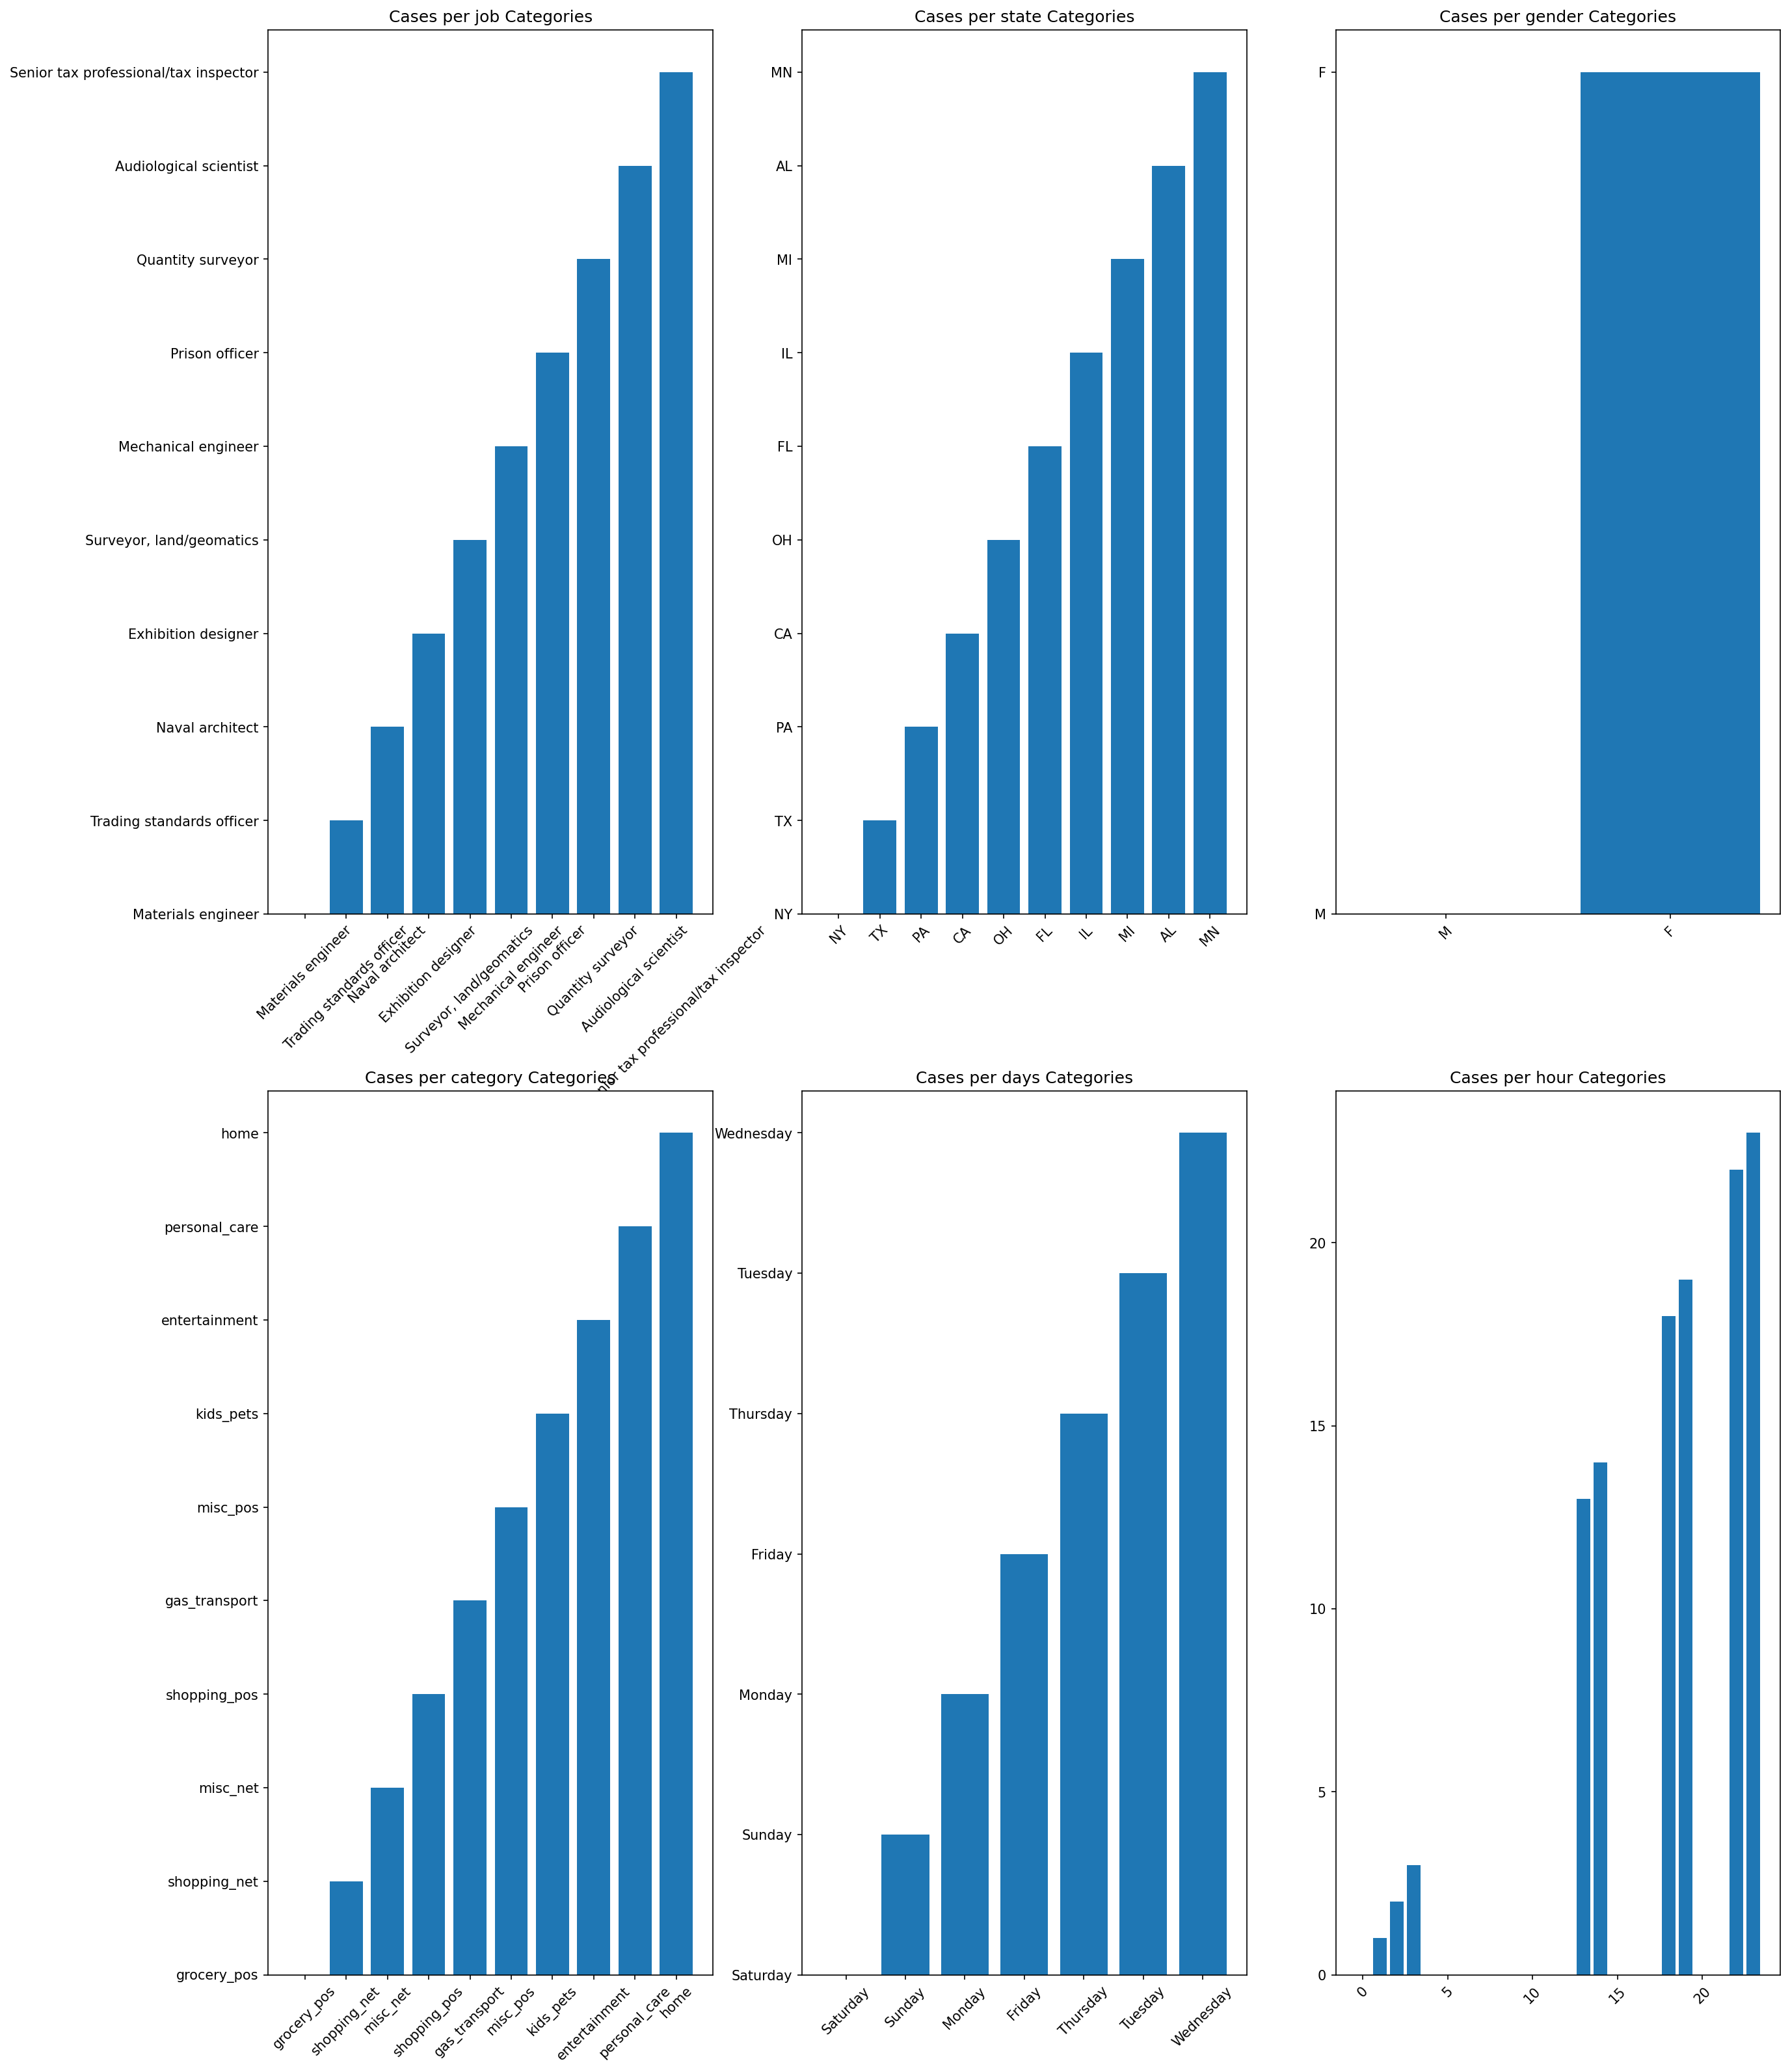

In [11]:
cols = ['job', 'state', 'gender', 'category', 'days', 'hour']
_, bar_plot = fraud_cat(cols)
bar_plot

이제 범주형으로 변환해야 하는 데이터에 대해서는 `pd.get_dummies`를 사용해 더미변수화 해 준다.

In [12]:
cols=['amt','gender','state','category',
      'city_pop','job','is_fraud','days','hour']
fraud_data_df=fraud_data[cols]

In [13]:
cat_cols=fraud_data[cols].select_dtypes(include='object').columns

In [14]:
def one_hot_encoded_cat(data, cat_cols):
    for i in cat_cols:
        df1 = pd.get_dummies(data[str(i)], 
                             prefix=i, drop_first=True)
        data.drop(str(i), axis=1, inplace=True)
        data = pd.concat([data, df1], axis=1)
    return data

In [15]:
fraud_df = one_hot_encoded_cat(fraud_data_df, cat_cols)

In [16]:
num_col = fraud_data_df.select_dtypes(exclude='object').columns
fraud_data_df = fraud_data_df[num_col]
del fraud_data_df['is_fraud']

다음은 각 변수 간의 상관관계를 확인하는 작업이다. 히트맵을 보면 각 변수의 상관관계는 낮다는 것을 확인할 수 있다.

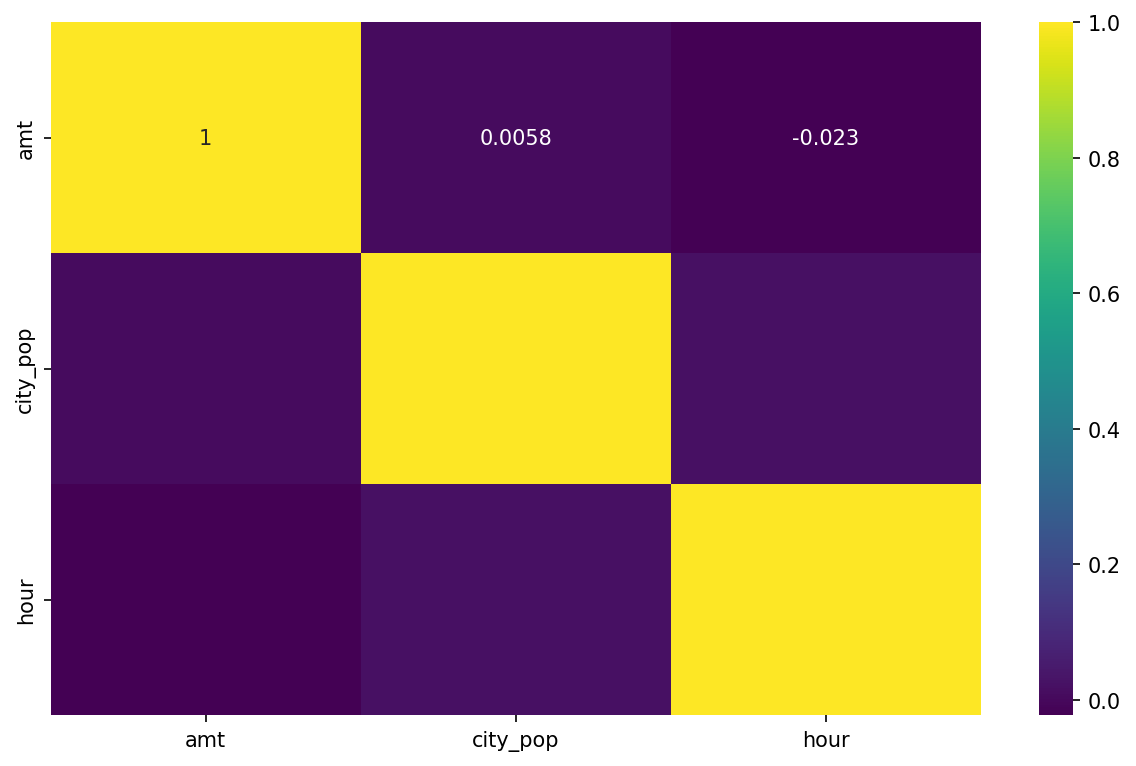

In [17]:
plt.figure(figsize=(10,6))
corrmat = fraud_data_df.corr()
top_corr_features = corrmat.index
heat_map = sns.heatmap(corrmat, annot=True, cmap="viridis")

## 사기 조사를 위한 지도학습

지도학습은 종속변수가 주어진 경우에 대해 수행하는 알고리즘이다. 주어진 feature 데이터에 대해 알맞는 종속변수 class를 예측하는 것이 주 목표이다. 이 장에서 실행하는 모델은 다음과 같다.

- 로지스틱 회귀 모형
- 의사결정 트리
- 랜덤 포레스트
- XGBoost(eXtreme Gradient Boosting)


### 언더 샘플링과 오버 샘플링

모델링을 수행하기 전, 클래스 불균형 문제를 바로잡아 주는 것은 매우 중요하다. 클래스 불균형 문제를 해결하기 위한 방법으로는 언더 샘플링과 오버 샘플링이 있다.

1. 언더 샘플링 : 이 방법은 다수 클래스에서 일부 샘플을 제거하여 클래스 간 균형을 맞추는 방법이다. 다수 클래스를 가진 데이터가 일부 제거되므로 학습 시간도 빨라지고 메모리도 적게 사용할 수 있다는 장점이 있다. 다만, 학습에 활용할 수 있는 데이터를 무작위로 버리는 셈이 되므로 전반적인 학습 성능에 떨어질 수 있다. 또한, 소수 클래스의 개수에 최대한 맞추기 때문에 클래스간 데이터 수의 차이가 너무 크지 않거나 소수 클래스의 데이터 개수가 충분할 때 사용하는 것이 바람직하다.

2. 오버 샘플링 : 이 방법은 언더 샘플링과는 반대로 소수 클래스의 샘플을 증가시켜 클래스 간 균형을 맞추는 방법이다. 다만, 단순히 복제하는 것은 특정 샘플에 편향된 모델을 학습을 유도하므로 소수 클래스 샘플을 합성하여 새로운 샘플을 생성하는 합성 샘플링(Synthetic Sampling) 방법을 많이 사용한다. 그 중에서도 Synthetic Minority Over-sampling Technique(이하, SMOTE)가 가장 많이 알려져있다. SMOTE는 두 샘플 사이에 각 feature의 보간(Interpolation)을 새로운 샘플에서 부여하는 방법으로 kNN(K-nearest neighbor)로 구해진 k개의 근접 샘플간의 보간을 활용한다. 이 방법을 사용하면 소수 클래스의 샘플을 늘리면서도 단순 복제가 아닌 유사 샘플을 늘리게 되어 클래스 불균형과 오버 피팅 문제를 동시에 해결할 수 있다. 다만, kNN을 기반하므로 데이터 셋이 클수록 계산 비용이 증가하고 이상치에 대해서도 합성을 진행하게 된다는 문제점이 있으므로, 소수 클래스의 샘플이 해당 클래스의 데이터 분포를 대변할 수 있으나 단지 수집된 개수가 적은 경우에 사용할 때 효율적이라고 볼 수 있다. 오버 샘플링에는 SMOTE 이외에도 ADASYN, Borderline-SMOTE 등 여러 방법이 존재하다.


<center>
    
<img src="./Image/sampling.png" width="1000px" height="500px">
    
</center>

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (classification_report,
                            confusion_matrix, f1_score)

In [19]:
non_fraud_class = fraud_df[fraud_df['is_fraud'] == 0]
fraud_class = fraud_df[fraud_df['is_fraud'] == 1]

In [20]:
non_fraud_count,fraud_count=fraud_df['is_fraud'].value_counts()
print('The number of observations in non_fraud_class:', non_fraud_count)
print('The number of observations in fraud_class:', fraud_count)

The number of observations in non_fraud_class: 1289169
The number of observations in fraud_class: 7506


다음은 sample 메소드를 사용해서 언더 샘플링을 수행하는 방법이다. 해당 메소드는 샘플링하고자 하는 데이터 수를 인수로 받아 랜덤으로 데이터를 추출하는 기능을 가지고 있다.

In [21]:
non_fraud_under = non_fraud_class.sample(fraud_count)
under_sampled = pd.concat([non_fraud_under, fraud_class], axis=0)
X_under = under_sampled.drop('is_fraud',axis=1)
y_under = under_sampled['is_fraud']

In [22]:
X_train_under, X_test_under, y_train_under, y_test_under =\
        train_test_split(X_under, y_under, random_state=0)

### SVC를 이용한 지도학습 분류기 생성

#### Log Uniform Distribution

일부 머신러닝 알고리즘은 흔히 음수가 아닌 Hyper Parameter만 허용한다. 이는 일부 아주 유명한 parameter에도 해당되는데, 예를 들어 `SVC` 분류기의 C나 RBF 커널의 `gamma`와 같은 경우이다. 0에서부터 적당히 큰 수, 예컨대 100정도 되는 사이에 균등 분포의 랜덤 수를 발생시킬 수 있다. 이 경우 99%의 발생된 수가 1보다 더 클 것으로 예상된다. 함수의 반응이 선형이 아닌 parameter의 실현 가능 영역을 탐색하는 데 가장 좋은 방법이 되지 못할 수 있다. 예를 들어, `SVC`에 있어 C의 반응은 0.01에서 1 사이의 증가나 1부터 100사이의 증가와 비슷할 수 있다. 그러므로, $U(0, 100)$ 분포로부터 C를 추출하는 것은 비효율적일 수 있다. 이런 경우에는 추출의 log 값이 균등한 분포로부터 값을 추출하는 것이 좀 더 효율적이다. Prado 교수는 이를 'Log Uniform Distribution'이라고 부르는데, 문헌 어디에도 해당하는 용어를 찾을 수 없다. 이제 이를 적절히 정의할 필요가 있다.

Random variable $x$는 오로지 $\log(x) \sim U[\log(a), \log(b)]$일 경우에만 $a > 0$와 $b > a$사이에서 로그 균등 분포를 따른다. 이 분포는 다음의 누적 분포 함수를 가진다.

$$F[x] = 
\begin{cases}
\frac{\log(x) - \log(a)}{\log(b) - \log(a)} &\text{ for } a \leq x \leq b \\
0 &\text{ for } x \leq a \\
1 &\text{ for } x \leq b
\end{cases}
$$

이로부터 확률 분포 함수를 도출할 수 있다.

$$
f[x] = 
\begin{cases}
\frac{1}{x\log \left[\frac{b}{a} \right]} &\text{ for } a \leq x \leq b \\
0 &\text{ for } x \leq a \\
0 &\text{ for } x \leq b
\end{cases}
$$

CDF는 로그의 및과는 무관하다는 점에 주목하자. 모든 $c$에 대해 $\frac{\log(x) - \log(a)}{\log(b) - \log(a)} = \frac{\log_c(x) - \log_c(a)}{\log_c(b) - \log_c(a)}$이므로 랜덤 변수는 $c$의 함수가 아니다.

다음은 logspace를 이용해서 SVC 분류기의 C 파라미터를 찾는 과정이다.

In [23]:
param_log = {'C': np.logspace(-4, 4, 4), 'penalty': ['l1', 'l2']}
log_grid = GridSearchCV(LogisticRegression(),
                        param_grid=param_log, n_jobs=-1)
log_grid.fit(X_train_under, y_train_under)
prediction_log = log_grid.predict(X_test_under)

In [24]:
conf_mat_log = confusion_matrix(y_true=y_test_under,
                                y_pred=prediction_log)
print('Confusion matrix:\n', conf_mat_log)
print('--' * 25)
print('Classification report:\n',
      classification_report(y_test_under, prediction_log))

Confusion matrix:
 [[1746   98]
 [ 467 1442]]
--------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.95      0.86      1844
           1       0.94      0.76      0.84      1909

    accuracy                           0.85      3753
   macro avg       0.86      0.85      0.85      3753
weighted avg       0.86      0.85      0.85      3753



### 의사결정 트리를 이용한 분류기 생성

다음은 의사결정 트리를 이용해 사기 분류 모델을 생성한 결과이다.

In [25]:
from sklearn.tree import DecisionTreeClassifier

In [26]:
param_dt = {'max_depth': [3, 5, 10],
            'min_samples_split': [2, 4, 6],
            'criterion': ['gini', 'entropy']}
dt_grid = GridSearchCV(DecisionTreeClassifier(),
                       param_grid=param_dt, n_jobs=-1)
dt_grid.fit(X_train_under, y_train_under)
prediction_dt = dt_grid.predict(X_test_under)

In [27]:
conf_mat_dt = confusion_matrix(y_true=y_test_under,
                               y_pred=prediction_dt)
print('Confusion matrix:\n', conf_mat_dt)
print('--' * 25)
print('Classification report:\n',
      classification_report(y_test_under, prediction_dt))

Confusion matrix:
 [[1801   43]
 [  85 1824]]
--------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      1844
           1       0.98      0.96      0.97      1909

    accuracy                           0.97      3753
   macro avg       0.97      0.97      0.97      3753
weighted avg       0.97      0.97      0.97      3753



### 랜덤 포레스트를 이용한 분류기 생성

일반적으로 단일 의사결정 트리는 과적합의 위험이 존재하여 배깅 모델인 랜덤 포레스트를 많이 사용한다. 

#### 분산 축소

배깅의 주요 장점은 예측의 분산을 줄이는 것이다. 그러므로 과적합을 해결하는 데 도움이 된다. 배깅된 예측의 분산은 배깅된 추정 계수, 단일 추정 계수 예측의 평균, 분산, 그리고 이들 예측 간의 평균 상관관계의 함수다
$$
\begin{matrix}
V \left[ \frac{1}{N} \sum_{i=1}^N \varphi_i[c]\right] \\

       = \frac{1}{N^2}\sum_{i=1}^N \left( \sum_{j=1}^N \sigma_{i,j}\right) \\

       = \frac{1}{N^2} \sum_{i=1}^N \left( \sigma_i^2 + \sum_{j \neq i}^N \sigma_i \sigma_j \rho_{i,j}\right) \\

       = \frac{1}{N^2} \sum_{i=1}^N \left( \bar{\sigma}^2 + \sum_{j \neq i}^N  \bar{\sigma} ^2 \bar{\rho}\right) \\

       = \frac{\bar{\sigma}^2 + (N-1)\bar{\sigma}^2 \bar{\rho}}{N} \\

       = \bar{\sigma}^2 \left( \bar {\rho} + \frac{1 - \bar{\rho}}{N}\right) 
\end{matrix}
$$

여기서 $\sigma_{i,j}$는 추정기 $i,j$에 의한 예측의 공분산이다. $\sum_{i=1}^N \bar{\sigma}^2 = \sum_{i=1}^N \sigma_i^2 \Leftrightarrow \bar{\sigma}^2 = N^{-1}\sum_{i=1}^N \sigma_i^2$이고, 

$\sum_{j \neq i}^N \bar{\sigma}^2 \bar{\rho} = \sum_{j \neq i}^N \sigma_i \sigma_j \sigma_{i,j} \Leftrightarrow \bar{\rho}^2 = \left( \sigma^2 N(N-1)\right)^{-1} \sum_{j \neq i}^N \sigma_i \sigma_j \sigma_{i,j}$이다. 

이때, $\bar{\rho} \rightarrow 1 \Rightarrow V \left[ \frac{1}{N} \sum_{i=1}^N \varphi_i[c]\right] \rightarrow \bar{\sigma}^2$ 이므로, 배깅이 $\bar{\rho} < 1$에 대해서만 효과적이라는 것을 식에서 보여준다. 

N개의 독립된 분류 기간의 다수결에 의해 k개 클래스를 예측하는 배깅 분류기를 생각해 보자. 예측은 {0,1}로 labeling할 수 있는데, 여기서 1은 정확한 예측을 의미한다. 분류기의 정확도는 예측을 1로 labeling하는 확률 $p$이다. 평균적으로 $Np$ 예측이 1로 labeling될 것이고, 분산은 $Np(1-p)$이다. 다수결 투표는 가장 많이 예측된 클래스가 관측된 경우에 정확한 예측을 한 것이다. 예를 들어서 $N = 10$이고 $k=3$일 때 배깅 분류기는 클래스 A가 관측되고, 투표 결과가 $[A, B, C] = [4, 3, 3]$이었다면 정확한 예측을 한 것이다. 그러나 배깅 분류기는 관측된 클래스가 A고, 투표 결과가 $[A, B, C] = [4,1,5]$라면 음성확한 예측을 한 것이다. 충분 조건은 이 label의 합이 $X > \frac{X}{2}$인 것이다. 필요조건은 $X > \frac{N}{k}$이고, 이는 다음과 같은 확률로 발생한다.

$$p \left[ X > \frac{N}{k}\right] = 1 - P\left[ X \leq \frac{N}{k}\right] = 1 - \sum_{i=0}^{\left\vert \frac{N}{k} \right\vert} {N \choose i} p^i (1-p)^{N-i}$$

이는 $N$이 충분히 크면, 예컨대 $N > p\left(p - \frac{1}{k}\right)^{-2}$이면 $p > 1 \Rightarrow P \left[ X > \frac{N}{k}\right] > p$이라는 것을 의미한다. 따라서 배깅 분류기의 정확도는 개별 분류기들의 평균 정확도를 능가한다. 계산 자원만 충분하다면 일반적으로 어떤 분류기든 배깅을 하는 것이 좋다. 그러나 배깅은 부스팅과 달리 성과가 좋지 않는 분류기의 정확도를 개선하지 못한다. 개별 학습기가 형편없는 분류기일 경우, 다수결 투표는 여전히 형편없을 것이다. $p > \frac{1}{k}$보다 $\bar{\rho} \ll 1$이 더 쉽기 때문에 대개 배깅은 편향을 줄이기보다 분산을 줄이는 데 더 성공적이다

다음은 랜덤 포레스트를 사용한 모델링 과정이다.

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
param_rf = {'n_estimators':[20,50,100] ,
         'max_depth':[3,5,10],
         'min_samples_split':[2,4,6],
         'max_features':['auto', 'sqrt', 'log2']}  
rf_grid = GridSearchCV(RandomForestClassifier(),
                      param_grid=param_rf, n_jobs=-1)
rf_grid.fit(X_train_under, y_train_under)
prediction_rf = rf_grid.predict(X_test_under)

In [30]:
conf_mat_rf = confusion_matrix(y_true=y_test_under,
                               y_pred=prediction_rf)
print('Confusion matrix:\n', conf_mat_rf)
print('--' * 25)
print('Classification report:\n', 
      classification_report(y_test_under, prediction_rf))

Confusion matrix:
 [[1787   57]
 [ 438 1471]]
--------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.97      0.88      1844
           1       0.96      0.77      0.86      1909

    accuracy                           0.87      3753
   macro avg       0.88      0.87      0.87      3753
weighted avg       0.88      0.87      0.87      3753



### Boosting

Kearns & Valiant(1989)는 약한 추정기들을 병합해 더 높은 정확도를 얻을 수 있는지의 의문을 제기한 최초의 사람들에 속한다. 그 후 Schapire(1990)는 통상 Boosting이라 부르는 방법을 사용에 질문에 대한 답이 양성적이라는 것을 증명했다. Boosting은 일반적으로 다음과 같이 작동한다.

1. 어떤 샘플 가중치에 따라 복원 랜덤 샘플링을 활용해 하나의 훈련셋을 생성한다
2. 하나의 추정기를 이 훈련 데이터셋을 사용해 적합화한다
3. 단일 추정기가 허용 임계값보다 높은 정확도를 얻으면 그 추정기는 유지하고, 그렇지 않으면 폐기한다
4. 잘못 분류된 관측값에는 더 많은 가중치를 부여하고, 정확히 분류된 가중치에는 더 적은 가중치를 부여한다.
5. N개의 추정기가 생성될 때까지 이 과정을 반복한다.
6. Ensemble 예측은 N 모델에서 나온 개별 예측의 가중 평균인데 가중치는 개별 추정기의 정확도에 따라서 결정된다

Boosting 알고리즘에는 종류가 굉장히 많으며, 대표적으로 다음과 같은 Boosting 모형이 사용된다

|       계열        |       Model       | Description                                                               |
|:---------------:|:-----------------:|:--------------------------------------------------------------------------|
| Adaptive method |   Ada Boosting    | 여러 약한 학습기를 순차적으로 훈련시킴. 각각의 학습기가 틀린 데이터 포인트에 가중치를 부여하여 다음 학습기가 더 잘 학습하도록 함 |
| Adaptive method |       SAMME       | AdaBoost의 이진 분류 문제를 다중 클래스에 대한 분류 문제로 확장한 모형                              |
| Adaptive method |    Brown Boost    | 데이터의 노이즈에 민감한 문제를 다루기 위해 설계된 AdaBoost 변형, 학습 과정에서 노이즈를 억제하는 특성이 있음        |
| Gradient method | Gradient Boosting | 오차에 가중치를 더하고 학습시키는 과정에서 경사 하강법을 사용하여 손실 함수를 최소화하는 방향으로 진행                 |
| Gradient method |     XG Boost      | Gradient Boosting과 같은 방식이지만, GPU 가속이 가능하려 빠른 병렬처리가 가능                     |
| Gradient method |     Light GBM     | Level wise 방법이 아닌 leaf wise 방법을 사용해 XG Boost의 속도를 개선                      |
| Gradient method |     CatBoost      | Level wise 방법 사용, 오차를 줄이는 방법에서 전체 오차가 아닌 부분 오차를 줄이는 것을 목적으로 overfit을 개선   |

더 자세한 내용은 https://hyunlee103.tistory.com/25 를 참고하면 된다.

다음은 부스팅 모델 중 하나인 XGBoost 모델을 설계하는 과정이다.

In [31]:
from xgboost import XGBClassifier

In [32]:
param_boost = {'learning_rate': [0.01, 0.1],
               'max_depth': [3, 5, 7],
               'subsample': [0.5, 0.7],
               'colsample_bytree': [0.5, 0.7],
               'n_estimators': [10, 20, 30]}
boost_grid = RandomizedSearchCV(XGBClassifier(),
                                param_boost, n_jobs=-1)
boost_grid.fit(X_train_under, y_train_under)
prediction_boost = boost_grid.predict(X_test_under)


In [33]:
conf_mat_boost = confusion_matrix(y_true=y_test_under,
                                  y_pred=prediction_boost)
print('Confusion matrix:\n', conf_mat_boost)
print('--' * 25)
print('Classification report:\n', 
      classification_report(y_test_under, prediction_boost))

Confusion matrix:
 [[1781   63]
 [  96 1813]]
--------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1844
           1       0.97      0.95      0.96      1909

    accuracy                           0.96      3753
   macro avg       0.96      0.96      0.96      3753
weighted avg       0.96      0.96      0.96      3753



## Cost-Based Fraud Examination

의료, 사기 등과 같은 민감한 분석에 서로 다른 샘플링 절차를 적용할 수 있지만 성과 척도가 서로 다른 오분류(False Positive, False Negative)가 미치는 다양한 경제적 영향을 고려하지 못한다는 점에 유의해야 한다. 예를 들자면, 병원의 경우는 병이 있는 사람에게 병이 없다고 판단하는 것(False Negative)이 병이 없는 사람에게 병이 있다고 판단하는 것(False Positive)보다 더 중요할 것이다. 하지만 법정의 경우 죄가 없는 사람에게 죄가 있다고 판단하는 것(False Positive)이 죄가 있는 사람에게 죄가 없는 것이라고 판단하는 것(False Negative)보다 더 중요할 것이다. 이렇듯 기법에 따라 서로 다른 오분류 비용이 발생한다면 이를 비용-민감(cost-sensitive) 분류기기라고 한다. 사기 사건도 비용-민감 분석의 대표적 예시이다. 거짓양성은 합법적인 거래를 차단하는 것이다. 거짓 음성은 사기를 감지하지 못한 것이다. 거짓 음성이 존재한다는 것은 통제 절차에 다양한 약점이 존재하고 잘못 설계된 운영 절차가 존재함을 암시할 수 있기 때문에 회사에 큰 의미가 있다. 따라서 이러한 유형에서는 거짓양성(False Positive)보더 거짓음성(False Negative)이 비용이 더 든다는 사실을 알 수 있다.

결과적으로 기관이 다양한 거짓음성 비용으로 인해 직면할 수 있는 총 비용은 다음과 같이 정리할 수 있다.

$$비용 = \Sigma_{i=1}^N y_i(c_iC_{TP_i} +(1-c_i)C_{FN_i}) + (1-y_i)c_iC_{FP_i}$$

여기서 $c_i$는 예측된 레이블의 수, $y_i$는 실제 레이블 수, $N$은 관찰 수, $C_{TP_i}$는 관리 비용에 해당하며 $C_{FN_i}$은 거래 금액을 나타낸다.

이제 해당 정보를 바탕으로 비용 민감 분류기를 만들어 보도록 하겠다.

In [34]:
fraud_df_sampled = fraud_df.sample(int(len(fraud_df) * 0.2))

In [35]:
cost_fp = 2
cost_fn = fraud_df_sampled['amt']
cost_tp = 2
cost_tn = 0
cost_mat = np.array([cost_fp * np.ones(fraud_df_sampled.shape[0]),
                     cost_fn,
                     cost_tp * np.ones(fraud_df_sampled.shape[0]),
                     cost_tn * np.ones(fraud_df_sampled.shape[0])]).T


총 비용을 계산해 모델 성능을 평가할수도 있다. 이때, 해당 스코어가 '비용'임을 감안하면 비용이 낮은 모델을 선택해야 할 것이다.

In [36]:
cost_log = conf_mat_log[0][1] * cost_fp + conf_mat_boost[1][0] * \
            cost_fn.mean() + conf_mat_log[1][1] * cost_tp
cost_dt = conf_mat_dt[0][1] * cost_fp + conf_mat_boost[1][0] * \
          cost_fn.mean() + conf_mat_dt[1][1] * cost_tp
cost_rf = conf_mat_rf[0][1] * cost_fp + conf_mat_boost[1][0] * \
          cost_fn.mean() + conf_mat_rf[1][1] * cost_tp
cost_boost = conf_mat_boost[0][1] * cost_fp + conf_mat_boost[1][0] * \
             cost_fn.mean() + conf_mat_boost[1][1] * cost_tp

## Saving Scores for Different ML Algorithms

비용 개선에 사용할 수 있는 척도 중 하나는 바로 절약 점수이다. 반센, 아오아다, 오테르스텐은 절약 점수 공식을 다음과 같이 정의한다.

$$비용 \ (f(S))= \Sigma_{i=1}^N ( \ y_i(c_iC_{TP_i} + (1-c_i)C_{FN_i}) +(1-y_i)(c_iC_{FP_i}+(1-c_i)C_{TN_i}) \ )$$

여기서 TP, FN, FP, TN은 각각 참양성, 거짓음성, 거짓양성, 참음성을 의미한다. $c_i$는 훈련 집합 S의 각 관측치 i에 대한 예측된 레이블을 의미한다.

$y_i$는 부류 레이블을 의미하며 1 또는 0의 값을 가진다.

그러면 절약 공식은 다음과 같이 결정된다.

$$절약 \ (f(S)) = \frac{cost_l(S)-cost(f(S))}{cost_l(S)}$$

여기서 $cost_l=min( \ cost(f_0(S)), cost(f_1(S)) \ )$를 의미하며 $f_0$은 부류 0, $c_0$을 예측하고 $f_1$은 부류 1, $c_1$의 관측값을 예측한다.

In [37]:
import joblib
import sys
import six
from sklearn.ensemble import _base
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
sys.modules['sklearn.ensemble.base'] = _base
from costcla.metrics import cost_loss, savings_score
from costcla.models import BayesMinimumRiskClassifier

In [38]:
X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test = \
train_test_split(fraud_df_sampled.drop('is_fraud', axis=1),
                           fraud_df_sampled.is_fraud, cost_mat,
                           test_size=0.2, random_state=0)

In [39]:
saving_models = []
saving_models.append(('Log. Reg.', 
                      LogisticRegression()))
saving_models.append(('Dec. Tree', 
                      DecisionTreeClassifier()))
saving_models.append(('Random Forest', 
                      RandomForestClassifier()))


In [40]:
saving_score_base_all = []

for name, save_model in saving_models:
    sv_model = save_model
    sv_model.fit(X_train, y_train)
    y_pred = sv_model.predict(X_test)
    saving_score_base = savings_score(y_test, y_pred, cost_mat_test)
    saving_score_base_all.append(saving_score_base)
    print('The saving score for {} is {:.4f}'. 
          format(name, saving_score_base))
    print('--' * 20)

The saving score for Log. Reg. is -0.3155
----------------------------------------
The saving score for Dec. Tree is 0.7424
----------------------------------------
The saving score for Random Forest is 0.6129
----------------------------------------


로짓 모형의 절약 점수가 음인 이유는 거짓음성 및 거짓 양성 예측수가 많기 때문이다. 이 경우 의사결정 트리가 가장 높은 절약점수를 가짐을 보여주고 있다.

In [41]:
f1_score_base_all = []

for name, save_model in saving_models:
    sv_model = save_model
    sv_model.fit(X_train, y_train)
    y_pred = sv_model.predict(X_test)
    f1_score_base = f1_score(y_test, y_pred, labels=cost_mat_test) 
    f1_score_base_all.append(f1_score_base)
    print('The F1 score for {} is {:.4f}'.
          format(name, f1_score_base))
    print('--' * 20)

The F1 score for Log. Reg. is 0.0000
----------------------------------------
The F1 score for Dec. Tree is 0.7217
----------------------------------------
The F1 score for Random Forest is 0.7378
----------------------------------------


## Cost-Sensitive Modeling

여기서는 costcla 라이브러리를 이용해 비용-민감 모델을 구축하는 법을 다룬다. 이런 작업을 하는 이유는 올바르게 분류거나 잘못 분류되거나 상관없이 동일한 비용을 부담한다고 가정하는 전통적 사기 모델은 사기에 관련된 오분류의 다양한 비용을 적절히 반영하지 못하기 때문이다. 이 부분에서는 절약 점수를 이용해 모델의 성능을 비교한다.

In [42]:
from costcla.models import CostSensitiveLogisticRegression
from costcla.models import CostSensitiveDecisionTreeClassifier
from costcla.models import CostSensitiveRandomForestClassifier

In [43]:
cost_sen_models = []
cost_sen_models.append(('Log. Reg. CS',
                        CostSensitiveLogisticRegression()))
cost_sen_models.append(('Dec. Tree CS',
                        CostSensitiveDecisionTreeClassifier()))
cost_sen_models.append(('Random Forest CS',
                        CostSensitiveRandomForestClassifier()))

In [44]:
saving_cost_all = []

for name, cost_model in cost_sen_models:
    cs_model = cost_model
    cs_model.fit(np.array(X_train, dtype=float), np.array(y_train, dtype=float),
                 cost_mat_train)
    y_pred = cs_model.predict(np.array(X_test, dtype=float))
    saving_score_cost = savings_score(np.array(y_test, dtype=float),
                                      np.array(y_pred, dtype=float), cost_mat_test)
    saving_cost_all.append(saving_score_cost)
    print('The saving score for {} is {:.4f}'.
          format(name, saving_score_cost))
    print('--'*20)

The saving score for Log. Reg. CS is 0.2656
----------------------------------------
The saving score for Dec. Tree CS is 0.8797
----------------------------------------
The saving score for Random Forest CS is 0.9237
----------------------------------------


결과를 확인하면 로지스틱 모델은 음의 절약점수를 얻으며, 이는 많은은 거짓음성(False Negative)이 생성된다는 것을 의미한다. 반대로 랜덤 포레스트는 높은 절약 점수를 생성했는데, 이는 매우 적은 수의 거짓음성(False Negative)이 생성된다는 것을 의미한다.

In [45]:
f1_score_cost_all = []

for name, cost_model in cost_sen_models:
    cs_model = cost_model
    cs_model.fit(np.array(X_train, dtype=float), np.array(y_train, dtype=float),
                 cost_mat_train)
    y_pred = cs_model.predict(np.array(X_test, dtype=float))
    f1_score_cost = f1_score(np.array(y_test),
                             np.array(y_pred), labels=cost_mat_test)
    f1_score_cost_all.append(f1_score_cost)
    print('The F1 score for {} is {:.4f}'. format(name,
                                                  f1_score_cost))
    print('--'*20)

The F1 score for Log. Reg. CS is 0.0101
----------------------------------------
The F1 score for Dec. Tree CS is 0.2876
----------------------------------------
The F1 score for Random Forest CS is 0.3482
----------------------------------------


## Bayesian Minimum Risk

https://www.youtube.com/watch?v=q64fO_qOJmg 링크 강의 참고

베이즈 결정은 비용 민감도를 고려해 사기를 모델링하는 다른 방법이다. 베이즈 최소 위험 모델은 다른 비용과 확률을 사용하는 의사결정 프로세스에 기반한다. 

베이즈 위험은 다음과 같이 정의된다.

$$R(\alpha_i \vert X) = E[L(h(X), y(X)) \ \vert \ h(X)=\alpha_i, X]$$

여기서 $\alpha$는 분류기의 분류 결과를 의미하며, $h(X), y(X)$는 각각 X 데이터가 주어질 때 분류기의 분류 결과와 실제 label을 의미한다. 또한 $L(.)$는 Loss function을 의미한다.

이를 정리하면 

$$R(\alpha_i \vert X) = E[L(\alpha_i, y(X)) \ \vert X]$$

가 된다.

실제 label을 $y_i$라 하고, $y_i$가 0부터 M-1개의 값을 갖는다고 하면 이는 

$$R(\alpha_i \vert X) = \Sigma_{j=0}^{M-1} L(\alpha_i, y_j) Prob(y(X)=y_j \vert X) $$

$$= \Sigma_{j=0}^{M-1} L(\alpha_i, y_j) q_j(X)$$

가 된다. 여기서 $q_j(X)$는 사후 분포를 의미한다.

이를 바탕으로 정리하면 거래가 사기로 예측되는 경우 전체 위험은 다음과 같이 정의된다.

$$R(c_f \vert S)=L(c_f\vert y_f)P(c_f\vert S)+L(c_f\vert y_l)P(c_l\vert S)$$

반면 거래가 합법적인 것으로 예측되면 전체 위험은 다음과 같이 나타난다.

$$R(c_l \vert S)=L(c_l\vert y_l)P(c_l\vert S)+L(c_l\vert y_f)P(c_f\vert S)$$

여기서 $y_f$및 $y_l$은 각각 사기 및 적법한 경우의 실제 부류이다. $L(c_f\vert y_f)$는 사기가 김지되고 실제 부류가 사기일 때의 비용을 이미한다. 마찬가지로, $L(c_l\vert y_l)$은 거래가 적법하다고 예측되고 실제 부류가 적법할 때의 비용을 나타낸다. 이와 반대로 $L(c_f\vert y_l)$는 거래가 사기로 예측되지만 실제로는 사기가 아닌 경우의 비용을 의미하며 $L(c_l\vert y_f)$는 거래가 합법으로 예측되었으나 실제로는 사기인 경우의 비용을 나타낸다. $P(c_l\vert S)$와 $P(c_f\vert S)$는 S가 주어질 때 각각 합법과 불법을 에측할 확률을 의미한다. 이 베이즈 최소 위험 공식은 다음과 같이 해석될 수 있다.

$$R(c_f\vert S)= C_{admin}P(c_f\vert S)+C_{admin}P(c_l\vert S)$$
$$R(c_l\vert S)= 0+C_{amt}P(c_l\vert S)$$

여기서 $admin$은 관리 비용을 의미하고 $amt$는 거래 금액을 의미한다. 여기서는 다음과 같은 경우를 사기로 분류하는 것을 의미한다.

$$R(c_f\vert S)\geq R(c_l\vert S)$$

또는 

$$C_{admin}P(c_f\vert S) + C_{admin}P(c_l\vert S) \geq C_{amt}P(c_l\vert S)$$

다음은 해당 논의를 바탕으로 예측 모델을 구현하는 코드이다.

In [46]:
saving_score_bmr_all = []

for name, bmr_model in saving_models:
    f = bmr_model.fit(X_train, y_train)
    y_prob_test = f.predict_proba(np.array(X_test))
    f_bmr = BayesMinimumRiskClassifier()
    f_bmr.fit(np.array(y_test), y_prob_test)
    y_pred_test = f_bmr.predict(np.array(y_prob_test),
                                cost_mat_test)
    saving_score_bmr = savings_score(y_test, y_pred_test,
                                     cost_mat_test)
    saving_score_bmr_all.append(saving_score_bmr)
    print('The saving score for {} is {:.4f}'.\
          format(name, saving_score_bmr))
    print('--' * 20)

The saving score for Log. Reg. is 0.8263
----------------------------------------
The saving score for Dec. Tree is 0.7491
----------------------------------------
The saving score for Random Forest is 0.9689
----------------------------------------


In [47]:
f1_score_bmr_all = []

for name, bmr_model in saving_models:
    f = bmr_model.fit(X_train, y_train)
    y_prob_test = f.predict_proba(np.array(X_test))
    f_bmr = BayesMinimumRiskClassifier()
    f_bmr.fit(np.array(y_test), y_prob_test)
    y_pred_test = f_bmr.predict(np.array(y_prob_test),
                                cost_mat_test)
    f1_score_bmr = f1_score(y_test, y_pred_test)
    f1_score_bmr_all.append(f1_score_bmr)
    print('The F1 score for {} is {:.4f}'.\
          format(name, f1_score_bmr))
    print('--'*20)

The F1 score for Log. Reg. is 0.1727
----------------------------------------
The F1 score for Dec. Tree is 0.6762
----------------------------------------
The F1 score for Random Forest is 0.4119
----------------------------------------


In [48]:
savings = [saving_score_base_all, saving_cost_all, saving_score_bmr_all]
f1 = [f1_score_base_all, f1_score_cost_all, f1_score_bmr_all]
saving_scores = pd.concat([pd.Series(x) for x in savings])
f1_scores = pd.concat([pd.Series(x) for x in f1])
scores = pd.concat([saving_scores, f1_scores], axis=1)
scores.columns = ['saving_scores', 'F1_scores']

In [49]:
model_names = ['Log. Reg_base', 'Dec. Tree_base', 'Random Forest_base',
               'Log. Reg_cs', 'Dec. Tree_cs', 'Random Forest_cs',
              'Log. Reg_bayes', 'Dec. Tree_bayes',
               'Random Forest_bayes']

f_1 score와 절약 점수를 모두 나열해보면 다음과 같은 결과를 얻을 수 있다.

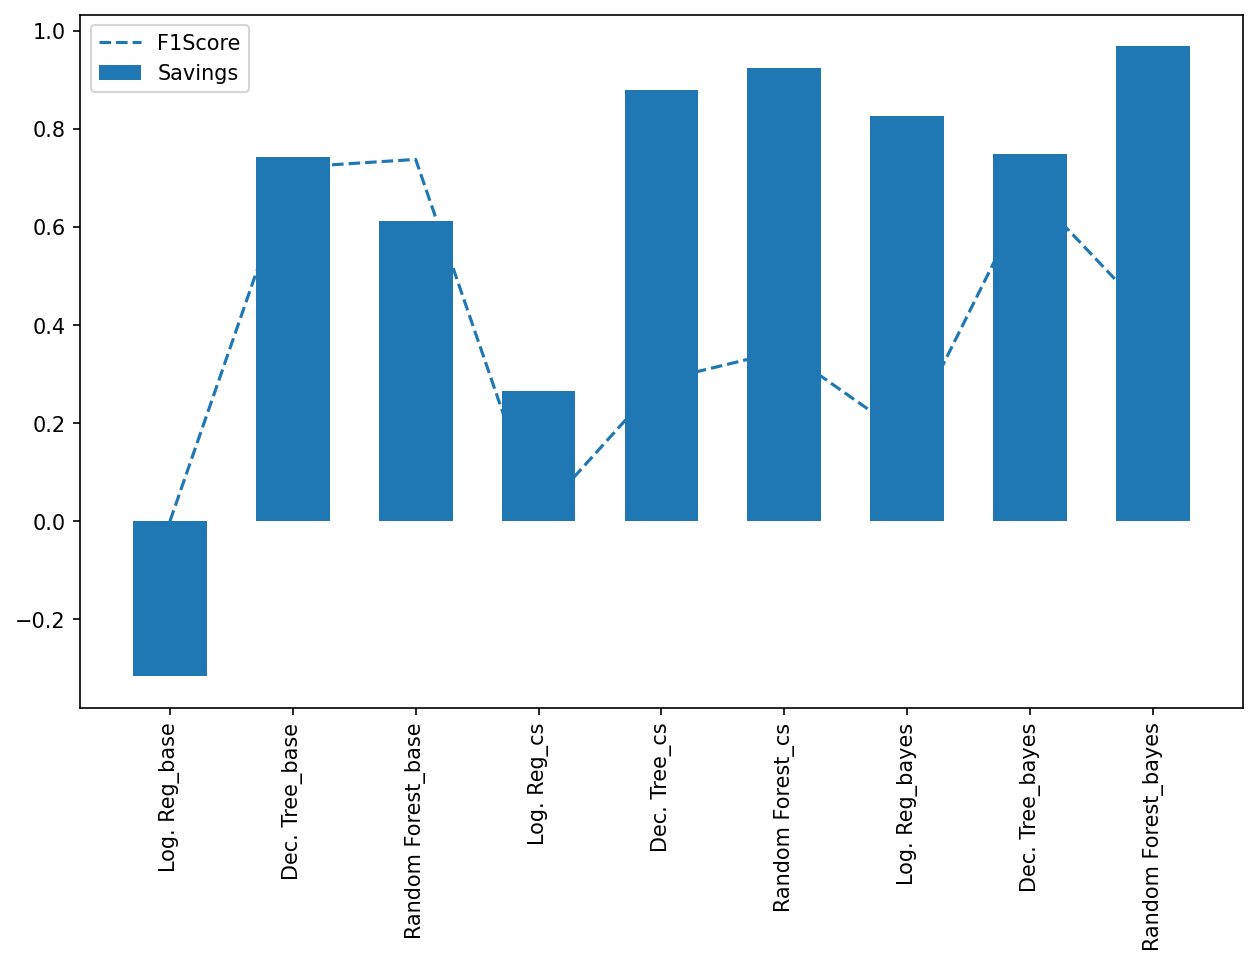

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(range(scores.shape[0]), scores["F1_scores"],
         "--", label='F1Score')
plt.bar(np.arange(scores.shape[0]), scores['saving_scores'],
        0.6, label='Savings')
_ = np.arange(len(model_names))
plt.xticks(_, model_names)
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

# Unsupervised Learning

비지도 학습 모델은 데이터의 숨겨진 특성을 추출하는 방식이다. 비지도 학습은 지도 학습과 라벨(종속변수)가가 지정되지 않은 데이터의 특성을 바탕으로 명시적인 지침이나 안내 없이 패턴과 유용한 정보를 발견한다. 비지도 학습은 자가 학습 알고리즘을 사용하여 라벨이나 사전 학습 없이 학습한다다. 대신 모델에는 라벨이 지정되지 않은 원시 데이터가 제공되며, 각 데이터로 작업하는 방법에 대한 명시적인 지침 없이 유사점, 차이점, 패턴을 기반으로 자체 규칙을 추론하고 정보를 구조화한다. 

비지도 학습 알고리즘은 대규모 데이터 세트를 클러스터로 구성하는 등 보다 복잡한 처리 작업에 적합하다는 특성을 가진다. 이는 데이터에서 이전에 감지되지 않은 패턴을 식별하는 데 유용하며 데이터를 분류하는 데 유용한 특성을 식별하는 데 도움이 될 수 있다. 

지도 학습 모델에 비해 비지도 학습 모델이 가지는 장점은 불균형 데이터 문제를 해결하기 위한 샘플링 절차가 필요 없다는 사실이다. 이 장에서는 SOM(Self-Organizing Map, 자기조직화지도)과 오토인코더 모델을 살펴보고자 한다.

### 자기조직화지도(SOM)

SOM은 고차원 공간에서 저차원 공간을 얻는 차원축소와 클러스터링을 모두 수행하는 비지도 방법이다. SOM은 사람이 눈으로 볼 수 있는 저차원(2차원 내지 3차원) 격자에 고차원 데이터의 각 개체들이 대응하도록 인공신경망과 유사한 방식의 학습을 통해 군집을 도출해내는 기법이다. 고차원의 데이터 원공간에서 유사한 개체들은 저차원에 인접한 격자들과 연결된다. 저차원 격자에서의 유사도는 고차원 입력 공간에서의 유사도를 최대한 보존하도록 학습된다.

SOM의 구조는 대략 다음 그림과 유사하다.

<center>
    
<img src="./Image/SOM.png" width="400px" height="300px">
    
</center>

이 그림에서 초록색 노드는 n차원 입력벡터를 의미하며, 주황색 노드는 2차원 격자를 의미한다. 즉 저차원 격자 하나에 유사한 고차원 입력백터가 속하게 되는 것이다. SOM 알고리즘은 임의의 n차원 입력벡터가 들어왔을 때 가장 가까운 격자벡터를 찾는다. 이 격자노드를 Winning node(승리 뉴런)라고 한다. 이 벡터에 대응되는 2차원상 격자에 해당 입력벡터를 할당하면서 바로 군집화도 수행된다.

SOM의 가장 독특한 특징은 다음과 같다.

- 변수 분포에 대한 가정이 존재하지 않는다
- 변수 간의 종속 구조를 파악한다
- 비선형 구조 처리 기능을 가진다
- 잡음 및 누락된 데이터 처리가 가능하다.

SOM 모델을 구현하기 위한 첫번째 과정은 Winning node를 식별하는 것이다. 이 식별 과정은 거리 척도를 이용해 식별되며 가장 대표적으로 사용되는 거리 척도는 민코프스키 거리척도이다. 이중 유클리드 거리척도는 그래디언트 하강 기법에서 잘 작동하므로 가장 일반적으로 사용된다.

다음 유클리드 공식이 주어지면 샘플과 가중치 사이의 거리를 찾을 수 있다.

$$\vert\vert \ (x_(t)-w_i(t)) \ \vert\vert= \sqrt{\Sigma_{j=1}^m (x_{tj}-w_{tji})^2}, \ i=1,2,3,...,n$$

여기서 $x_t$는 샘플 데이터, $w_{tji}$는 가중치를 의미한다. i는 i번째 노드를 의미한다. Winning node k(t)는 다음과 같이 결정된다.

$$k(t)= \underset{i}{argmin} \vert\vert \ x(t)-w_i(t) \ \vert \vert$$

승리 노드를 찾은 이후 승리 노드와 해당 노드와 인접한 노드에 대한 가중치를 갱신한다. 가중치 갱신은 학습률이 주어질 때 다음과 같이 수행된다.

$$w_i(t+1)=w_i(t)+\lambda[x(t)-w_i(t)]$$

여기서 w_i(t)는 t번째 반복에서 승리한 노드 i의 가중치고 $\lambda$는 학습률을 의미한다.

이 식을 자세히 보면, $x(t)-w_i(t)>0$이면 $w_i(t+1)$이 더 커져 $x(t)$에 가까워지며, $x(t)-w_i(t)<0$이면 $w_i(t+1)$이 더 작아져 $x(t)$에 가까워지게 된다. 즉, winning node의 가중치가 결국 입력 백터에 가까워지게 된다는 의미이다.

또한 여기서 가중치의 적응 비율(학습률)은 조정하려는 노드가 승리 노드에서 멀어질수록 감소한다. 이는 이웃함수 

$$h_{ki}(t)=exp(-\frac{d_{ki}^2}{2\sigma^2(t)})$$

에 의해 정의된다. 여기서 $d_{ki}^2$은 승리 뉴런과 관련 뉴런 사이의 거리를 나타내며, $\sigma^2(t)$는 반복 t에서의 승리 뉴런을 중심으로 하는 반경을 나타낸다.

이 모든 것을 고려하면 가중치의 갱신 과정은 다음과 같이 결정된다.

$$w_i(t+1)=w_i(t)+\lambda h_{ki}(t)[x(t)-w_i(t)]$$

이를 요약하면 다음과 같다.

1. 가중치 초기화 : 가중치에 임의의 값을 할당한다. PCA 가중치를 할당하는 경우도 있으나 데이터가 고차원이 될 수록 임의 값 할당이 더욱 효과적이라는 연구 결과가 존재한다.

2. 승리 뉴런을 찾는다.

3. 가중치를 갱신한다

4. 이 과정을 모든 입력 데이터에 대해 반복한다.

이를 사기 데이터에 적용하기 위해, 사기 데이터에는 두 부류가 있으므로 SOM의 output은 $2\times 1$ 구조를 가져야 한다. 해당 과정을 코드로 구현하면 다음과 같다.

In [51]:
from sklearn.preprocessing import StandardScaler
standard = StandardScaler()
scaled_fraud = standard.fit_transform(X_under)

In [52]:
from sklearn_som.som import SOM
som = SOM(m=2, n=1, dim=scaled_fraud.shape[1])
som.fit(scaled_fraud)
predictions_som = som.predict(np.array(scaled_fraud))

In [53]:
predictions_som = np.where(predictions_som == 1, 0, 1)

In [54]:
print('Classification report:\n', 
      classification_report(y_under, predictions_som))

Classification report:
               precision    recall  f1-score   support

           0       0.34      0.22      0.27      7506
           1       0.42      0.56      0.48      7506

    accuracy                           0.39     15012
   macro avg       0.38      0.39      0.37     15012
weighted avg       0.38      0.39      0.37     15012



그리고 실제 라벨과 SOM이 예측한 라벨을 비교해보면 다음과 같은 결과를 얻을 수 있다.

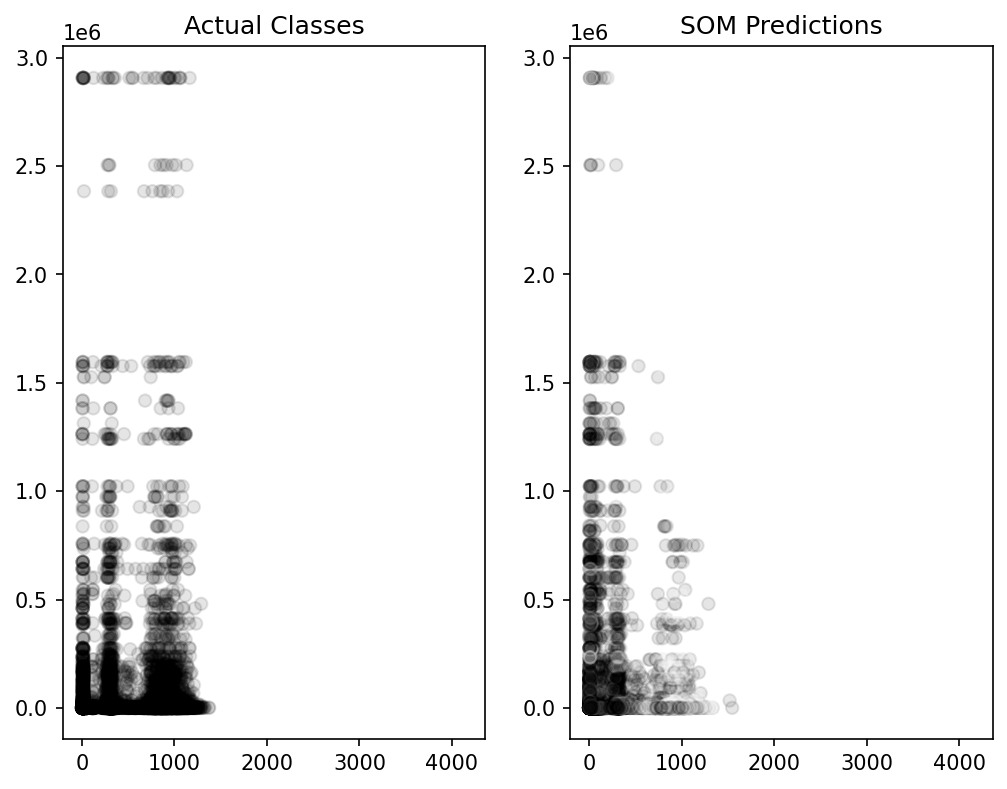

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
x = X_under.iloc[:,0]
y = X_under.iloc[:,1]

ax[0].scatter(x, y, alpha=0.1, cmap='Greys', c=y_under)
ax[0].title.set_text('Actual Classes')
ax[1].scatter(x, y, alpha=0.1, cmap='Greys', c=predictions_som) 
ax[1].title.set_text('SOM Predictions')

## Autoencoder

#### 인코딩(encoding)과 디코딩(decoding)

- 인코더는 입력 샘플의 특징을 추출해 잠재 공간, 즉 인코더에 의해 정의된 숨겨진 구조화된 값 집합에 매핑하는 함수를 의미한다.

- 디코더는 이 잠재 공간의 요소를 사전 정의된 타겟 도메인으로 매핑해 재구성하는 함수를 의미한다.


  <img src="https://image.slidesharecdn.com/aes171113-180510014736/95/-48-638.jpg?cb=1525916931">

  <sub>[이미지 출처] https://www.slideshare.net/NaverEngineering/ss-96581209</sub>

#### 오토인코더(Autoencoder, AE)

- 입력을 저차원 잠재공간으로 인코딩한 후 디코딩하여 복원하는 네트워크를 오토인코더라고 부른다.

- 설명을 위해 x를 입력, h를 은닉층이라고 하면 인코더 함수는 $h=f(x)$, 디코더 함수는 $r=g(h)$로 표현할 수 있다. 이때 $g(f(x))=x$인 경우는 단순히 복제를 하는 경우로, 오토인코더가 특징을 추출해 재구성하는 이상적인 상황이 아니게 된다.

- 결론적으로 오토인코더는 원래 입력의 저차원 표현을 갖도록 지식을 압축하는 네트워크 구조를 가지고 있다고 요약이 가능하다.

  <img src="https://miro.medium.com/max/1200/1*nqzWupxC60iAH2dYrFT78Q.png">

  <sub>[이미지 출처] https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f</sub>

이 장에서는 가장 일반적으로 사용되는 세 가지 오토인코더에 대해 살펴본다

- 불완전 오토인코더
- 희소 오토인코더
- 잡음 제거 오토인코더

#### 불완전 오토인코더

불완전 오토인코더(Undercomplete autoencoder)는 은닉층 h가 훈련 데이터 x보다 작은 차원을 가지므로 가장 기본적인 유형의 오토인코더이다. 따라서 뉴런 수는 훈련 데이터 수보다 더 적다. 이 오토인코더의 목적은 손실함수를 최소화하는 데이터의 잠재 공간(Latent space)을 포착하는 것이다. 즉, $L(x, g(f(x)))$를 찾는 것이다. 여기서 $L$은 손실함수를 의미한다. 이 불완전 오토인코더는 PCA보다 더 강력한 비선형 차원축소 기법으로도 이해가 가능하다. PCA는 원래 데이터를 설명하는 저차원 초평면을 발견하려고 시도하는 반면, 오토인코더는 비선형 다양체(다양체는 연속적이고 교차하지 않는 표면으로 간단한 용어로 정의됨)를 학습할 수 있기 때문이다.

#### 희소 오토인코더

희소 오토인코더(Sparse autoencoder)는 재구성 오류에 희소성을 부과해 편향-분산 딜레마를 해결하고자 한 모델이다. 다른 말로 하면 희소 오토인코더는 lLatent space의 뉴런 개수를 제한하는 방법을 사용한다. 이는 dropout에서 일부 뉴런을 의도적으로 누락시켜 훈련하는 것과 비슷하다. 이때의 최적화는 다음과 같이 수행된다.

$$\underset{g, f}{argmin} \ L(x, g(f(x)))+\lambda(h)$$

여기서 $g(f(x))$는 디코더를 의미하며, $h$는 인코더 출력층 노드 수를 의미한다. 즉 인코더 출력층 노드 수에 패널티를 부과하는 것을 의미한다.

<center>
    
<img src="./Image/sparse.png" width="800px" height="600px">
    
</center>

#### 잡음 제거 오토인코더

잡음 제거 오토인코더(Denoising autoencoder)는 위 희소 오토인코더에서 $\lambda$를 사용하는 대신 입력 데이터에 잡음을 추가하고 해당 잡음을 포함해서 학습하는 것을 의미한다. 즉, 입력 데이터는 잡음이 섞인 데이터가 되며 출력 결과는 잡음을 제거한 데이터가 된다. 따라서 잡음 제거 오토인코더의 경우 다음과 같이 손실함수가 변경되게 된다.

$$L(x, g(f(\hat{x})))$$

여기서 $\hat{x}$는 입력값에 잡음을 섞은 결과를 의미한다.

다음은 파이썬을 이용해 오토인코더를 구현한 코드이다.

In [56]:
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout
from keras import regularizers

In [57]:
fraud_df[['amt','city_pop','hour']] = StandardScaler().\
fit_transform(fraud_df[['amt','city_pop','hour']])

In [58]:
X_train, X_test = train_test_split(fraud_df,
                                   test_size=0.2, random_state=123)
X_train[X_train['is_fraud'] == 0]
X_train = X_train.drop(['is_fraud'], axis=1).values
y_test = X_test['is_fraud']
X_test = X_test.drop(['is_fraud'], axis=1).values

In [59]:
autoencoder = keras.Sequential()
autoencoder.add(Dense(X_train_under.shape[1], activation='tanh',
                      activity_regularizer=regularizers.l1(10e-5),
                      input_dim= X_train_under.shape[1]))
#encoder
autoencoder.add(Dense(64, activation='tanh'))
autoencoder.add(Dense(32, activation='relu'))
#decoder
autoencoder.add(Dense(32, activation='elu'))
autoencoder.add(Dense(64,activation='tanh'))
autoencoder.add(Dense(X_train_under.shape[1], activation='elu'))
autoencoder.compile(loss='mse',
                    optimizer='adam')
autoencoder.summary();

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 566)            │       320,922 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        36,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 566)            │        36,790 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 399,248 (1.52 MB)

 Trainable params: 399,248 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
batch_size = 200
epochs = 100

In [61]:
history = autoencoder.fit(np.array(X_train, dtype=float), np.array(X_train, dtype=float),
                          shuffle=True,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=(np.array(X_test, dtype=float), np.array(X_test, dtype=float)),
                          verbose=0).history

In [62]:
autoencoder_pred = autoencoder.predict(np.array(X_test, dtype=float))
mse = np.mean(np.power(X_test - autoencoder_pred, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test}, dtype=float)
error_df.describe()

8105/8105 ━━━━━━━━━━━━━━━━━━━━ 4s 508us/step


,reconstruction_error,true_class
count,259335.000000,259335.000000
mean,0.004858,0.005668
std,0.004898,0.075075
min,0.001173,0.000000
25%,0.003872,0.000000
50%,0.005009,0.000000
75%,0.005438,0.000000
max,0.958751,1.000000


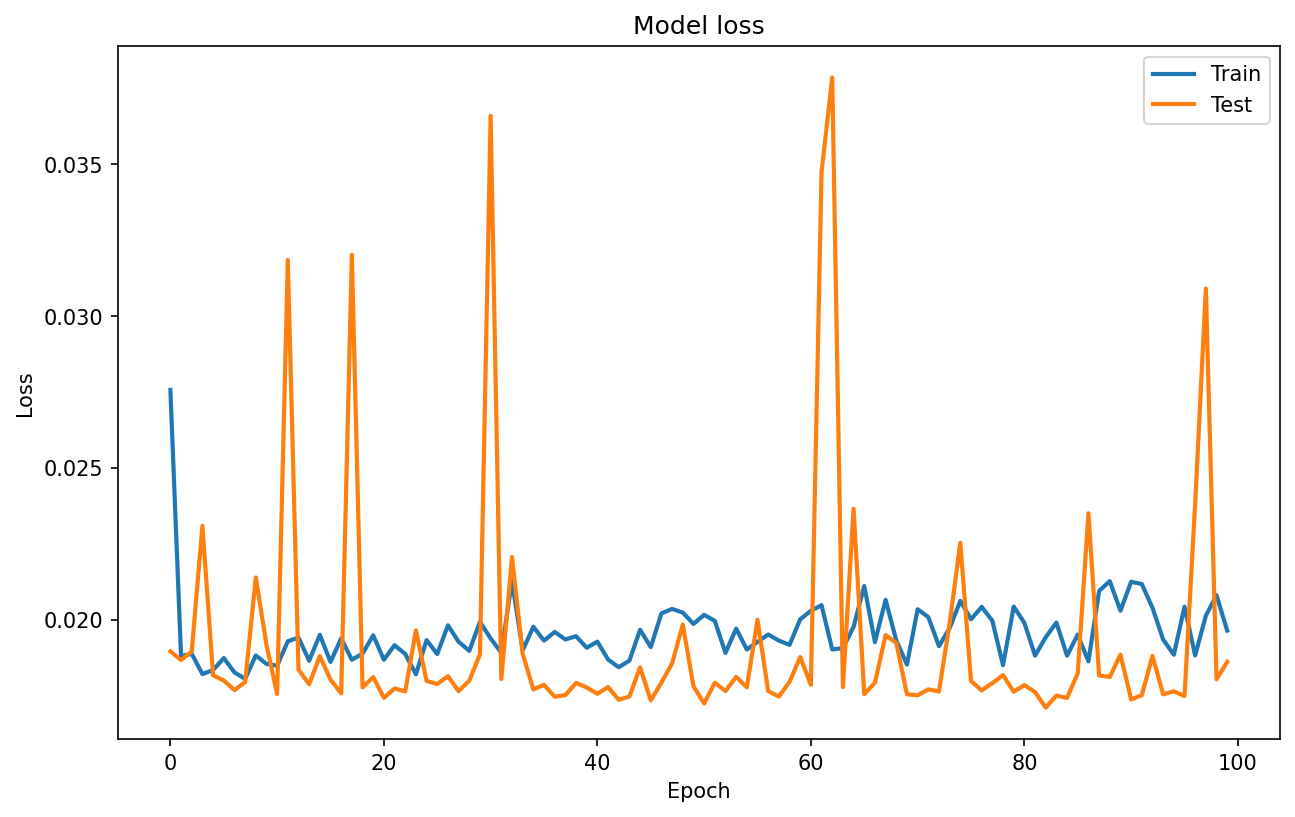

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()